In [1]:
import matplotlib.pyplot as plt
import matplotlib.animation
%matplotlib ipympl
import numpy as np
import pandas as pd

from scipy.spatial import KDTree, cKDTree
from scipy.ndimage import uniform_filter1d
from scipy.signal import savgol_filter
from scipy.optimize import curve_fit

import joblib
from tqdm import tqdm
import pims
import trackpy as tp
from numba import njit, prange

from yupi import Trajectory
import yupi.graphics as yg
import yupi.stats as ys

show_verb = True
save_verb = True
anim_show_verb = False

In [2]:
data = pims.open('../data/video/movie.mp4')
rawTrajs = pd.read_csv("../data/csv/Processed_data2.csv")
red_particle_idx = 17
rawTrajs.loc[rawTrajs.particle!=red_particle_idx, ["color"]] = "#00007F"
rawTrajs.loc[rawTrajs.particle==red_particle_idx, ["color"]] = "#FF0000"
colors = rawTrajs.loc[rawTrajs.frame==0, 'color'].values

nDrops = len(rawTrajs.loc[rawTrajs.frame==0])
nFrames = max(rawTrajs.frame) + 1
print(f"nDrops:{nDrops}")
print(f"nFrames:{nFrames} --> {nFrames/10:.2f} s")

# WINDOWED ANALYSIS PARAMETERS
window = 3200 # 320 s
stride = 100 # 10 s
print(f"window of {window/10} s, stride of {stride/10} s")
startFrames = np.arange(0, nFrames-window, stride, dtype=int)
endFrames = startFrames + window
nSteps = len(startFrames)
print(f"number of steps: {nSteps}")


# step 10 with a 10 fps video --> 1 s  
units = "px/s"
default_kwargs_blue = {"color": "#00FFFF", "ec": (0, 0, 0, 0.6), "density": True}
default_kwargs_red = {"color": "#EE4B2B", "ec": (0, 0, 0, 0.6), "density": True}

11:28:55 [WARNING] deprecated pixel format used, make sure you did set range correctly


nDrops:50
nFrames:32000 --> 3200.00 s
window of 320.0 s, stride of 10.0 s
number of steps: 288


In [4]:
# Trajectory Smoothing: using a Savgol Filter in order to drop the noise due to the tracking procedure
smoothTrajs = rawTrajs.copy()
windLen = 30
orderofPoly = 2
for i in range(nDrops):
    smoothTrajs.loc[smoothTrajs.particle == i, "x"] = savgol_filter(rawTrajs.loc[rawTrajs.particle == i].x.values,
                                                                    windLen, orderofPoly)
    smoothTrajs.loc[smoothTrajs.particle == i, "y"] = savgol_filter(rawTrajs.loc[rawTrajs.particle == i].y.values,
                                                                    windLen, orderofPoly)

# Mean Squared Displacement

In [ ]:
pxDimension = 1 # has to be fixed 
fps = 10 # fps of the video
maxLagtime = 1000 # maximum lagtime to be considered

In [ ]:
# Power Law fit
def powerLawFit(funct, fit, powerlawExponents):
    for i in range(nDrops):
        powerlawFit = tp.utils.fit_powerlaw(funct[i], plot = False) 
        powerlawExponents[i] = powerlawFit.n.values 
        fit[i] = powerlawFit.A.values * np.array(funct.index)**powerlawExponents[i] 
    return fit, powerlawExponents

## Individual MSD

In [ ]:
im = tp.imsd(rawTrajs, mpp = pxDimension, fps = fps, max_lagtime = maxLagtime)
fit, powerlawExponents = powerLawFit(im, np.zeros((nDrops, maxLagtime)), np.zeros(nDrops))

fig, (ax, ax1) = plt.subplots(1, 2, figsize=(10, 4))
ax.plot(im.index, im)
ax.set(xscale = 'log', yscale = 'log', xlabel = "Time Lag [s]", ylabel = "MSD [px^2]")
ax.grid()
ax1.scatter(np.arange(nDrops), powerlawExponents, c = colors)
ax1.set(xlabel = "Particle ID", ylabel = "Powerlaw Exponent")
ax1.grid()
plt.suptitle("Mean Squared Displacement - Raw Trajectories")
plt.tight_layout()
if save_verb: plt.savefig("../results/mean_squared_displacement/IMSD_raw.png", dpi = 500)
if show_verb: 
    plt.show()
else:
    plt.close()

In [ ]:
im_smooth = tp.imsd(smoothTrajs, mpp = pxDimension, fps = fps, max_lagtime = maxLagtime)
fit_smooth, powerlawExponents_smooth = powerLawFit(im_smooth, np.zeros((nDrops, maxLagtime)), np.zeros(nDrops))

fig, (ax, ax1) = plt.subplots(1, 2, figsize=(10, 4))
ax.plot(im.index, im_smooth)
ax.set(xscale = 'log', yscale = 'log',  xlabel = "Time Lag [s]", ylabel = "MSD [px^2]")
ax.grid()
ax1.scatter(np.arange(nDrops), powerlawExponents_smooth, c = colors)
ax1.set(xlabel = "Particle ID", ylabel = "Powerlaw Exponent")
ax1.grid()
plt.suptitle("Mean Squared Displacement - Smooth Trajectories")
plt.tight_layout()
if save_verb: plt.savefig("../results/mean_squared_displacement/IMSD_smooth.png", dpi = 500)
if show_verb: 
    plt.show()
else:
    plt.close()

## Ensamble MSD

In [ ]:
MSD_mean = np.array(im)
MSD_blue = MSD_mean[:, [x for x in range(nDrops) if x != red_particle_idx]].mean(axis = 1)
MSD_blue_std = MSD_mean[:,[x for x in range(nDrops) if x != red_particle_idx]].std(axis = 1)
MSD_red = MSD_mean[:, red_particle_idx]

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (10, 4))
ax.plot(im.index, MSD_blue, 'b-', label = "Blue particles") 
ax.fill_between(im.index, MSD_blue - MSD_blue_std, MSD_blue + MSD_blue_std, alpha=0.5, edgecolor='#00FFFF', facecolor='#F0FFFF')
ax.plot(im.index, MSD_red, 'r-', label = "Red particle")
ax.set(xscale = 'log', yscale = 'log', ylabel = r'$\langle \Delta r^2 \rangle$ [$px^2$]',   
         xlabel = 'lag time $t$ [s]', title = "MSD per particle type - Raw Trajectories")
ax.legend()
ax.grid()
if save_verb: plt.savefig("../results/mean_squared_displacement/EMSD_raw.png", dpi = 500, bbox_inches = 'tight')
if show_verb:
    plt.show()
else:
    plt.close()

In [ ]:
MSD_mean_smooth = np.array(im_smooth)
MSD_blue_smooth = MSD_mean_smooth[:, [x for x in range(nDrops) if x != red_particle_idx]].mean(axis = 1)
MSD_blue_std_smooth = MSD_mean_smooth[:,[x for x in range(nDrops) if x != red_particle_idx]].std(axis = 1)
MSD_red_smooth = MSD_mean_smooth[:, red_particle_idx]

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (10, 4))
ax.plot(im_smooth.index, MSD_blue_smooth, 'b-', label = "Blue particles") 
ax.fill_between(im.index, MSD_blue_smooth - MSD_blue_std_smooth, MSD_blue_smooth + MSD_blue_std_smooth,
                     alpha=0.5, edgecolor='#00FFFF', facecolor='#F0FFFF')
ax.plot(im_smooth.index, MSD_red_smooth, 'r-', label = "Red particle")
ax.set(xscale = 'log', yscale = 'log', ylabel = r'$\langle \Delta r^2 \rangle$ [$px^2$]',   
         xlabel = 'lag time $t$ [s]', title = "MSD per particle type - Smooth Trajectories")
ax.legend()
ax.grid()
if save_verb: plt.savefig("../results/mean_squared_displacement/EMSD_smooth.png", dpi = 500, bbox_inches = 'tight')
if show_verb:
    plt.show()
else:
    plt.close()

## Windowed Analysis

### Individual MSD - Raw Trajectories

In [ ]:
MSD_windowed = []
fit_windowed = np.zeros((nSteps, nDrops, maxLagtime-10))
powerlawExponents_windowed = np.zeros((nSteps, nDrops))

for i in tqdm(range(nSteps)):
    trajs = rawTrajs.loc[rawTrajs.frame.between(startFrames[i], endFrames[i])]
    MSD_windowed.append(tp.imsd(trajs, mpp = pxDimension, fps = fps, max_lagtime = maxLagtime))
    fit_windowed[i], powerlawExponents_windowed[i] = powerLawFit(MSD_windowed[i].iloc[10:], np.zeros((nDrops, maxLagtime-10)), np.zeros(nDrops))

In [ ]:
fit_windowed[0]

In [ ]:
fig, (ax, ax1) = plt.subplots(2, 1, figsize=(8, 5))
anim_running = True

def onClick(event):
    global anim_running
    if anim_running:
        ani.event_source.stop()
        anim_running = False
    else:
        ani.event_source.start()
        anim_running = True

def update_graph(step):
    for i in range(nDrops):
        graphic_data[i].set_ydata(np.array(MSD_windowed[step].iloc[:, i]))
    title.set_text(f"Mean Squared Displacement - Raw Trajectories - window [{startFrames[step]/10} - {endFrames[step]/10}] s")
    graph1.set_ydata(powerlawExponents_windowed[step])
    return graphic_data, graph1,


title = ax.set_title(f"Mean Squared Displacement - Raw Trajectories - window [{startFrames[0]/10} - {endFrames[0]/10}] s")
graphic_data = []
for i in range(nDrops):
    graphic_data.append(ax.plot(MSD_windowed[i].index, np.array(MSD_windowed[0].iloc[:, i]))[0])
ax.set(xscale = 'log', yscale = 'log', ylabel = r'$\langle \Delta r^2 \rangle$ [$px^2$]', xlabel = 'lag time $t$ [s]', ylim=(0.5, 10**5))
ax.grid()

ax1.set(xlabel = "Particle ID", ylabel = r"$\beta$", ylim = (0, 2))
graph1, = ax1.plot(np.arange(nDrops), powerlawExponents_windowed[0], '.', markersize = 10)
ax1.axvline(x = red_particle_idx, color = 'r', linestyle = '--')

plt.tight_layout()
fig.canvas.mpl_connect('button_press_event', onClick)
ani = matplotlib.animation.FuncAnimation(fig, update_graph, nSteps, interval = 5, blit=False)
if save_verb: ani.save('../results/mean_squared_displacement/IMSD_windowed_raw.mp4', fps=30, extra_args=['-vcodec', 'libx264'])
if anim_show_verb:
    plt.show()
else:
    plt.close()

In [ ]:
# version 2
fig, (ax, ax1) = plt.subplots(2, 1, figsize=(8, 5))
anim_running = True

def onClick(event):
    global anim_running
    if anim_running:
        ani.event_source.stop()
        anim_running = False
    else:
        ani.event_source.start()
        anim_running = True

def update_graph(step):
    for i in range(nDrops):
        graphic_data[i].set_ydata(np.array(MSD_windowed[step].iloc[:, i]))
        graphic_data2[i].set_data(startFrames[:step]/10, powerlawExponents_windowed[:step, i])
    title.set_text(f"Mean Squared Displacement - Raw Trajectories - window [{startFrames[step]/10} - {endFrames[step]/10}] s")
    ax1.set_xlim(0, startFrames[step]/10 + 0.0001)
    return graphic_data, graphic_data2,


title = ax.set_title(f"Mean Squared Displacement - Raw Trajectories - window [{startFrames[0]/10} - {endFrames[0]/10}] s")
graphic_data = []
for i in range(nDrops):
    if i == red_particle_idx:
        graphic_data.append(ax.plot(MSD_windowed[i].index, np.array(MSD_windowed[0].iloc[:, i]), color=colors[i], alpha = 1)[0])
    else:
        graphic_data.append(ax.plot(MSD_windowed[i].index, np.array(MSD_windowed[0].iloc[:, i]), color=colors[i], alpha = 0.3)[0])
ax.set(xscale = 'log', yscale = 'log', ylabel = r'$\langle \Delta r^2 \rangle$ [$px^2$]', xlabel = 'lag time $t$ [s]', ylim = (0.5, 10**5))
ax.grid()

graphic_data2 = []
for i in range(nDrops):
    if i == red_particle_idx:
        graphic_data2.append(ax1.plot(startFrames[0]/10, powerlawExponents_windowed[0, i], color=colors[i], alpha = 1)[0])
    else:
        graphic_data2.append(ax1.plot(startFrames[0]/10, powerlawExponents_windowed[0, i], color=colors[i], alpha = 0.3)[0])
ax1.set(xlabel = 'Window time [s]', ylabel = r'$\beta$', ylim = (0, 2))
ax1.grid()

plt.tight_layout()
fig.canvas.mpl_connect('button_press_event', onClick)
ani = matplotlib.animation.FuncAnimation(fig, update_graph, nSteps, interval = 5, blit=False)
if save_verb: ani.save('../results/mean_squared_displacement/IMSD_windowed_raw_v2.mp4', fps=30, extra_args=['-vcodec', 'libx264'])
if anim_show_verb:
    plt.show()
else:
    plt.close()

### Individual MSD - Smooth Trajectories

In [ ]:
MSD_windowed_smooth = []
fit_windowed_smooth = np.zeros((nSteps, nDrops, maxLagtime-10))
powerlawExponents_windowed_smooth = np.zeros((nSteps, nDrops))

for i in tqdm(range(nSteps)):
    trajs = smoothTrajs.loc[smoothTrajs.frame.between(startFrames[i], endFrames[i])]
    MSD_windowed_smooth.append(tp.imsd(trajs, mpp = pxDimension, fps = fps, max_lagtime = maxLagtime))
    fit_windowed_smooth[i], powerlawExponents_windowed_smooth[i] = powerLawFit(MSD_windowed_smooth[i].iloc[10:], np.zeros((nDrops, maxLagtime-10)), np.zeros(nDrops))

In [ ]:
fig, (ax, ax1) = plt.subplots(2, 1, figsize=(8, 5))
anim_running = True

def onClick(event):
    global anim_running
    if anim_running:
        ani.event_source.stop()
        anim_running = False
    else:
        ani.event_source.start()
        anim_running = True

def update_graph(step):
    for i in range(nDrops):
        graphic_data[i].set_ydata(np.array(MSD_windowed_smooth[step].iloc[:, i]))
    title.set_text(f"Mean Squared Displacement - Smooth Trajectories - window [{startFrames[step]/10} - {endFrames[step]/10}] s")
    graph1.set_ydata(powerlawExponents_windowed_smooth[step])
    return graphic_data, graph1,


title = ax.set_title(f"Mean Squared Displacement - Smooth Trajectories - window [{startFrames[0]/10} - {endFrames[0]/10}] s")
graphic_data = []
for i in range(nDrops):
    graphic_data.append(ax.plot(MSD_windowed_smooth[i].index, np.array(MSD_windowed_smooth[0].iloc[:, i]))[0])
ax.set(xscale = 'log', yscale = 'log', ylabel = r'$\langle \Delta r^2 \rangle$ [$px^2$]', xlabel = 'lag time $t$ [s]', ylim=(0.05, 10**5))
ax.grid()

ax1.set(xlabel = "Particle ID", ylabel = r"$\beta$", ylim = (0, 2))
graph1, = ax1.plot(np.arange(nDrops), powerlawExponents_windowed_smooth[0], '.', markersize = 10)
ax1.axvline(x = red_particle_idx, color = 'r', linestyle = '--')

plt.tight_layout()
fig.canvas.mpl_connect('button_press_event', onClick)
ani = matplotlib.animation.FuncAnimation(fig, update_graph, nSteps, interval = 5, blit=False)
if save_verb: ani.save('../results/mean_squared_displacement/IMSD_windowed_smooth.mp4', fps=30, extra_args=['-vcodec', 'libx264'])
if anim_show_verb:
    plt.show()
else:
    plt.close()

In [ ]:
# version 2
fig, (ax, ax1) = plt.subplots(2, 1, figsize=(8, 5))
anim_running = True

def onClick(event):
    global anim_running
    if anim_running:
        ani.event_source.stop()
        anim_running = False
    else:
        ani.event_source.start()
        anim_running = True

def update_graph(step):
    for i in range(nDrops):
        graphic_data[i].set_ydata(np.array(MSD_windowed_smooth[step].iloc[:, i]))
        graphic_data2[i].set_data(startFrames[:step]/10, powerlawExponents_windowed_smooth[:step, i])
    title.set_text(f"Mean Squared Displacement - Smooth Trajectories - window [{startFrames[step]/10} - {endFrames[step]/10}] s")
    ax1.set_xlim(0, startFrames[step]/10 + 0.0001)
    return graphic_data, graphic_data2,


title = ax.set_title(f"Mean Squared Displacement - Smooth Trajectories - window [{startFrames[0]/10} - {endFrames[0]/10}] s")
graphic_data = []
for i in range(nDrops):
    if i == red_particle_idx:
        graphic_data.append(ax.plot(MSD_windowed_smooth[i].index, np.array(MSD_windowed_smooth[0].iloc[:, i]), color=colors[i], alpha = 1)[0])
    else:
        graphic_data.append(ax.plot(MSD_windowed_smooth[i].index, np.array(MSD_windowed_smooth[0].iloc[:, i]), color=colors[i], alpha = 0.3)[0])
ax.set(xscale = 'log', yscale = 'log', ylabel = r'$\langle \Delta r^2 \rangle$ [$px^2$]', xlabel = 'lag time $t$ [s]', ylim = (0.1, 10**5))
ax.grid()

graphic_data2 = []
for i in range(nDrops):
    if i == red_particle_idx:
        graphic_data2.append(ax1.plot(startFrames[0]/10, powerlawExponents_windowed_smooth[0, i], color=colors[i], alpha = 1)[0])
    else:
        graphic_data2.append(ax1.plot(startFrames[0]/10, powerlawExponents_windowed_smooth[0, i], color=colors[i], alpha = 0.3)[0])
ax1.set(xlabel = 'Window time [s]', ylabel = r'$\beta$', ylim = (0, 2))
ax1.grid()

plt.tight_layout()
fig.canvas.mpl_connect('button_press_event', onClick)
ani = matplotlib.animation.FuncAnimation(fig, update_graph, nSteps, interval = 5, blit=False)
if save_verb: ani.save('../results/mean_squared_displacement/IMSD_windowed_smooth_v2.mp4', fps=30, extra_args=['-vcodec', 'libx264'])
if anim_show_verb:
    plt.show()
else:
    plt.close()

### Ensemble MSD - Raw Trajectories 

In [ ]:
MSD_windowed_mean = np.array(MSD_windowed)
MSD_windowed_blue = MSD_windowed_mean[:, :, [x for x in range(nDrops) if x != red_particle_idx]].mean(axis = 2)
MSD_windowed_blue_std = MSD_windowed_mean[:, :, [x for x in range(nDrops) if x != red_particle_idx]].std(axis = 2)
MSD_windowed_red = MSD_windowed_mean[:, :, red_particle_idx]

In [ ]:
df_blue = []
df_red = []
for k in range(nSteps):
    df_blue.append(pd.DataFrame(data = MSD_windowed_blue[k], index = MSD_windowed[k].index, columns = ['msd']))
    df_red.append(pd.DataFrame(data = MSD_windowed_red[k], index = MSD_windowed[k].index, columns = ['msd']))

In [ ]:
fit_mean = np.zeros((nSteps, 2, maxLagtime-10))
powerlawExponents_mean = np.zeros((nSteps, 2))
powerlawExponents_std = np.zeros((nSteps, 2))

for k in range(nSteps):
    powerlawFit = tp.utils.fit_powerlaw(df_blue[k].iloc[10:], plot = False)  
    powerlawExponents_mean[k, 0] = powerlawFit.n.values 
    powerlawExponents_std[k, 0] = powerlawFit.stderr.values 
    fit_mean[k, 0, :] = powerlawFit.A.values * np.arange(1.1, 100.1, 0.1)**powerlawExponents_mean[k, 0]

    powerlawFit = tp.utils.fit_powerlaw(df_red[k].iloc[10:], plot = False)  
    powerlawExponents_mean[k, 1] = powerlawFit.n.values 
    powerlawExponents_std[k, 1] = powerlawFit.stderr.values 
    fit_mean[k, 1, :] = powerlawFit.A.values * np.arange(1.1, 100.1, 0.1)**powerlawExponents_mean[k, 1]

In [ ]:
Y1_msd = MSD_windowed_blue - MSD_windowed_blue_std
Y2_msd = MSD_windowed_blue + MSD_windowed_blue_std

fig, (ax, ax1) = plt.subplots(2, 1, figsize=(8, 5))
anim_running = True

def onClick(event):
    global anim_running
    if anim_running:
        ani.event_source.stop()
        anim_running = False
    else:
        ani.event_source.start()
        anim_running = True

def update_graph(step):
    # update title
    title.set_text(f"Mean Squared Displacement - Raw Trajectories - window {startFrames[step]/10} - {endFrames[step]/10} seconds")
    # update MSD
    graphic_data[0].set_ydata(MSD_windowed_blue[step])
    graphic_data[1].set_ydata(MSD_windowed_red[step])
    # update fill between
    path = fill_graph.get_paths()[0]
    verts = path.vertices
    verts[1:1000+1, 1] = Y1_msd[step, :]
    verts[1000+2:-1, 1] = Y2_msd[step, :][::-1]
    # update powerlaw exponents
    line.set_data(startFrames[:step]/10, powerlawExponents_mean[:step, 0])
    line1.set_data(startFrames[:step]/10, powerlawExponents_mean[:step, 1]) 
    line2.set_data(startFrames[:step]/10, np.ones(step)) 
    ax1.set_xlim(0, (startFrames[step]+10)/10)
    return graphic_data, fill_graph, line, line1, 


title = ax.set_title(f"Mean Squared Displacement - Raw Trajectories - window {startFrames[0]/10} - {endFrames[0]/10} seconds")
graphic_data = []
graphic_data.append(ax.plot(df_blue[0].index, MSD_windowed_blue[0], 'b-', alpha=0.5, label = "Blue particles")[0] )
graphic_data.append(ax.plot(df_red[0].index, MSD_windowed_red[0], 'r-' , label = "Red particle")[0] )
fill_graph = ax.fill_between(df_blue[0].index, Y1_msd[0], Y2_msd[0], alpha=0.5, edgecolor='#F0FFFF', facecolor='#00FFFF')
ax.set(xscale = 'log', yscale = 'log', ylabel = r'$\langle \Delta r^2 \rangle$ [$px^2$]', xlabel = 'lag time $t$ [s]', ylim=(0.5, 10**5))
ax.legend()
ax.grid()

line, = ax1.plot(startFrames[0]/10, powerlawExponents_mean[0, 0], 'b-', alpha = 0.5, label = 'Blue particles')
line1, = ax1.plot(startFrames[0]/10, powerlawExponents_mean[0, 1], 'r-', alpha = 0.5, label = 'Red particle')
line2, = ax1.plot(startFrames[0]/10, 1, 'k-')
ax1.legend()
ax1.grid()
ax1.set(xlabel = 'Window time [s]', ylabel = r'$\beta$', ylim = (0, 2))

plt.tight_layout()
fig.canvas.mpl_connect('button_press_event', onClick)
ani = matplotlib.animation.FuncAnimation(fig, update_graph, nSteps, interval = 5, blit=False)
if save_verb: ani.save('../results/mean_squared_displacement/EMSD_windowed_raw.mp4', fps=30, extra_args=['-vcodec', 'libx264'])
if anim_show_verb:
    plt.show()
else:
    plt.close()

In [ ]:
# version 2 trial, need to fix the fill between part

if 0:
    Y1_msd = MSD_windowed_blue - MSD_windowed_blue_std
    Y2_msd = MSD_windowed_blue + MSD_windowed_blue_std

    Y1 = powerlawExponents_mean[:, 0] - powerlawExponents_std[:, 0]
    Y2 = powerlawExponents_mean[:, 0] - powerlawExponents_std[:, 0]

    fig, (ax, ax1) = plt.subplots(2, 1, figsize=(8, 5))
    anim_running = True

    def onClick(event):
        global anim_running
        if anim_running:
            ani.event_source.stop()
            anim_running = False
        else:
            ani.event_source.start()
            anim_running = True

    def update_graph(step):
        # update title
        title.set_text(f"{startFrames[step]/10} - {endFrames[step]/10} seconds")
        # update MSD
        graphic_data[0].set_ydata(MSD_windowed_blue[step])
        graphic_data[1].set_ydata(MSD_windowed_red[step])
        # update fill between
        path = fill_graph.get_paths()[0]
        verts = path.vertices
        verts[1:1000+1, 1] = Y1_msd[step, :]
        verts[1000+2:-1, 1] = Y2_msd[step, :][::-1]
        # update powerlaw exponents
        line.set_data(startFrames[:step]/10, powerlawExponents_mean[:step, 0])
        line1.set_data(startFrames[:step]/10, powerlawExponents_mean[:step, 1]) 
        ax1.set_xlim(0, (startFrames[step]+10)/10)
        #ax1.set_xlim(0, startFrames[step]+10)
        # update fill between 2
        path1 = fill_graph1.get_paths()[0]
        verts1 = path1.vertices
        verts1[1:step+1] = Y1[step]
        verts1[step+2:-1] = Y2[step][::-1]
        return graphic_data, fill_graph, line, line1, 


    title = ax.set_title(f"Mean Squared Displacement - window {startFrames[0]/10} - {endFrames[0]/10} seconds")
    graphic_data = []
    graphic_data.append(ax.plot(df_blue[0].index, MSD_windowed_blue[0], 'b-', alpha=0.5, label = "Blue particles")[0] )
    graphic_data.append(ax.plot(df_red[0].index, MSD_windowed_red[0], 'r-' , label = "Red particles")[0] )
    fill_graph = ax.fill_between(df_blue[0].index, Y1_msd[0], Y2_msd[0], alpha=0.5, edgecolor='#F0FFFF', facecolor='#00FFFF')
    ax.set(xscale = 'log', yscale = 'log', ylabel = r'$\langle \Delta r^2 \rangle$ [$px^2$]', xlabel = 'lag time $t$ [s]', ylim=(0.5, 10**5))
    ax.legend()
    ax.grid()

    line, = ax1.plot(startFrames[0]/10, powerlawExponents_mean[0, 0], 'b-', label = 'blue')
    fill_graph1 = ax1.fill_between(startFrames[:1]/10, Y1[:1], Y2[:1], alpha=0.5,
                        edgecolor='#F0FFFF', facecolor='#00FFFF')
    line1, = ax1.plot(startFrames[0]/10, powerlawExponents_mean[0, 1], 'r-', label = 'red')
    ax1.legend()
    ax1.set(xlabel = 'Time [s]', ylabel = r'$\beta$', ylim = (0, 2))

    plt.tight_layout()
    fig.canvas.mpl_connect('button_press_event', onClick)
    ani = matplotlib.animation.FuncAnimation(fig, update_graph, nSteps, interval = 5, blit=False)
    #if save_verb: ani.save('../results/mean_squared_displacement/EMSD_windowed_raw_v2.mp4', fps=30, extra_args=['-vcodec', 'libx264'])
    if 1:
        plt.show()
    else:
        plt.close()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.set_title(f"Power Law Exponents")
ax.plot(startFrames/10, powerlawExponents_mean[:, 0], 'b-', alpha = 0.5, label = 'blue particles')
ax.fill_between(startFrames/10, powerlawExponents_mean[:, 0] - powerlawExponents_std[:, 0],     
                    powerlawExponents_mean[:, 0] + powerlawExponents_std[:, 0],
                    alpha=0.5, edgecolor='#F0FFFF', facecolor='#00FFFF')
ax.plot(startFrames/10, powerlawExponents_mean[:, 1], 'r-', alpha = 0.5, label = 'red particle ')
ax.plot(startFrames/10, np.ones(nSteps), 'k-')
ax.legend()
ax.grid()
ax.set(xlabel = 'Window time [s]', ylabel = r'$\beta$', ylim = (0, 2))
plt.tight_layout()
if save_verb: plt.savefig('../results/mean_squared_displacement/EMSD_beta_raw.png', dpi=500, bbox_inches='tight')
if show_verb:
    plt.show()
else:
    plt.close()

### Ensemble MSD - Smooth Trajectories 

In [ ]:
MSD_windowed_mean_smooth = np.array(MSD_windowed_smooth)
MSD_windowed_blue_smooth = MSD_windowed_mean_smooth[:, :, [x for x in range(nDrops) if x != red_particle_idx]].mean(axis = 2)
MSD_windowed_blue_std_smooth = MSD_windowed_mean_smooth[:, :, [x for x in range(nDrops) if x != red_particle_idx]].std(axis = 2)
MSD_windowed_red_smooth = MSD_windowed_mean_smooth[:, :, red_particle_idx]

In [ ]:
df_blue_smooth = []
df_red_smooth = []
for k in range(nSteps):
    df_blue_smooth.append(pd.DataFrame(data = MSD_windowed_blue_smooth[k], index = MSD_windowed_smooth[k].index, columns = ['msd']))
    df_red_smooth.append(pd.DataFrame(data = MSD_windowed_red_smooth[k], index = MSD_windowed_smooth[k].index, columns = ['msd']))

In [ ]:
fit_mean_smooth = np.zeros((nSteps, 2, maxLagtime-10))
powerlawExponents_mean_smooth = np.zeros((nSteps, 2))
powerlawExponents_std_smooth = np.zeros((nSteps, 2))

for k in range(nSteps):
    powerlawFit = tp.utils.fit_powerlaw(df_blue_smooth[k].iloc[10:], plot = False)  
    powerlawExponents_mean_smooth[k, 0] = powerlawFit.n.values 
    powerlawExponents_std_smooth[k, 0] = powerlawFit.stderr.values 
    fit_mean_smooth[k, 0, :] = powerlawFit.A.values * np.arange(1.1, 100.1, 0.1)**powerlawExponents_mean_smooth[k, 0]

    powerlawFit = tp.utils.fit_powerlaw(df_red_smooth[k].iloc[10:], plot = False)  
    powerlawExponents_mean_smooth[k, 1] = powerlawFit.n.values 
    powerlawExponents_std_smooth[k, 1] = powerlawFit.stderr.values 
    fit_mean_smooth[k, 1, :] = powerlawFit.A.values * np.arange(1.1, 100.1, 0.1)**powerlawExponents_mean_smooth[k, 1]

In [ ]:
Y1_msd_smooth = MSD_windowed_blue_smooth - MSD_windowed_blue_std_smooth
Y2_msd_smooth = MSD_windowed_blue_smooth + MSD_windowed_blue_std_smooth

fig, (ax, ax1) = plt.subplots(2, 1, figsize=(8, 5))
anim_running = True

def onClick(event):
    global anim_running
    if anim_running:
        ani.event_source.stop()
        anim_running = False
    else:
        ani.event_source.start()
        anim_running = True

def update_graph(step):
    # update title
    title.set_text(f"Mean Squared Displacement - Smooth Trajectories - window [{startFrames[step]/10} - {endFrames[step]/10}] s")
    # update MSD
    graphic_data[0].set_ydata(MSD_windowed_blue_smooth[step])
    graphic_data[1].set_ydata(MSD_windowed_red_smooth[step])
    # update fill between
    path = fill_graph.get_paths()[0]
    verts = path.vertices
    verts[1:1000+1, 1] = Y1_msd_smooth[step, :]
    verts[1000+2:-1, 1] = Y2_msd_smooth[step, :][::-1]
    # update powerlaw exponents
    line.set_data(startFrames[:step]/10, powerlawExponents_mean_smooth[:step, 0])
    line1.set_data(startFrames[:step]/10, powerlawExponents_mean_smooth[:step, 1]) 
    line2.set_data(startFrames[:step]/10, np.ones(step)) 
    ax1.set_xlim(0, (startFrames[step]+10)/10)
    return graphic_data, fill_graph, line, line1, 


title = ax.set_title(f"Mean Squared Displacement - Smooth Trajectories - window [{startFrames[0]/10} - {endFrames[0]/10}] s")
graphic_data = []
graphic_data.append(ax.plot(df_blue_smooth[0].index, MSD_windowed_blue_smooth[0], 'b-', alpha=0.5, label = "Blue particles")[0] )
graphic_data.append(ax.plot(df_red_smooth[0].index, MSD_windowed_red_smooth[0], 'r-' , label = "Red particle")[0] )
fill_graph = ax.fill_between(df_blue_smooth[0].index, Y1_msd_smooth[0], Y2_msd_smooth[0], alpha=0.5, edgecolor='#F0FFFF', facecolor='#00FFFF')
ax.set(xscale = 'log', yscale = 'log', ylabel = r'$\langle \Delta r^2 \rangle$ [$px^2$]', xlabel = 'lag time $t$ [s]', ylim=(0.1, 10**5))
ax.legend()
ax.grid()

line, = ax1.plot(startFrames[0]/10, powerlawExponents_mean_smooth[0, 0], 'b-', alpha = 0.5, label = 'Blue particles')
line1, = ax1.plot(startFrames[0]/10, powerlawExponents_mean_smooth[0, 1], 'r-', alpha = 0.5, label = 'Red particles')
line2, = ax1.plot(startFrames[0]/10, 1, 'k-')
ax1.legend()
ax1.grid()
ax1.set(xlabel = 'Window time [s]', ylabel = r'$\beta$', ylim = (0, 2))

plt.tight_layout()
fig.canvas.mpl_connect('button_press_event', onClick)
ani = matplotlib.animation.FuncAnimation(fig, update_graph, nSteps, interval = 5, blit=False)
if save_verb: ani.save('../results/mean_squared_displacement/EMSD_windowed_smooth.mp4', fps=30, extra_args=['-vcodec', 'libx264'])
if anim_show_verb:
    plt.show()
else:
    plt.close()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.set_title(f"Power Law Exponents")
ax.plot(startFrames/10, powerlawExponents_mean_smooth[:, 0], 'b-', alpha = 0.5, label = 'blue particles')
ax.fill_between(startFrames/10, powerlawExponents_mean_smooth[:, 0] - powerlawExponents_std_smooth[:, 0],     
                    powerlawExponents_mean_smooth[:, 0] + powerlawExponents_std_smooth[:, 0],
                    alpha=0.5, edgecolor='#F0FFFF', facecolor='#00FFFF')
ax.plot(startFrames/10, powerlawExponents_mean_smooth[:, 1], 'r-', alpha = 0.5, label = 'red particle ')
ax.plot(startFrames/10, np.ones(nSteps), 'k-')
ax.legend()
ax.grid()
ax.set(xlabel = 'Window time [s]', ylabel = r'$\beta$', ylim = (0, 2))
if save_verb: plt.savefig('../results/mean_squared_displacement/EMSD_beta_smooth.png', dpi = 500, bbox_inches='tight')
if show_verb:
    plt.show()
else:
    plt.close()

# Speed Distribution

$$ \huge p(v) = \frac{v}{\sigma^2} e^{-\frac{v^2}{2\sigma^2}} $$

In [9]:
# fit of the velocity distrubtions with a Maxwell-Boltzmann 2D distribution
def MB_2D(v, sigma):
    return v/(sigma**2) * np.exp(-v**2/(2*sigma**2))

bin_borders = np.arange(0, 100, .2)
bin_centers = np.arange(0, 100, .2)[:-1] + .2 / 2
x_interval_for_fit = np.linspace(bin_borders[0], bin_borders[-1], 10000)

In [ ]:
# raw trajectories
blueTrajs = []
redTraj = []
for i in range(0, nDrops):
    if i == red_particle_idx:
        p = rawTrajs.loc[rawTrajs.particle == i, ["x","y"]]
        redTraj.append(Trajectory(p.x, p.y, dt = 1/10, traj_id=i))
    else:
        p = rawTrajs.loc[rawTrajs.particle == i, ["x","y"]]
        blueTrajs.append(Trajectory(p.x, p.y, dt = 1/10, traj_id=i))
    

# smooth trajectories
blueTrajs_smooth = []
redTraj_smooth = []
for i in range(0, nDrops):
    if i == red_particle_idx:
        p = smoothTrajs.loc[smoothTrajs.particle == i, ["x","y"]]
        redTraj_smooth.append(Trajectory(p.x, p.y, dt = 1/10, traj_id=i))
    else:
        p = smoothTrajs.loc[smoothTrajs.particle == i, ["x","y"]]
        blueTrajs_smooth.append(Trajectory(p.x, p.y, dt = 1/10, traj_id=i))
    

In [ ]:
v_blue = ys.speed_ensemble(blueTrajs, step=10)
v_red = ys.speed_ensemble(redTraj, step=10)

# fit to get effective temperature 
bin_heights, _ = np.histogram(v_blue, bins = bin_borders, density = True)
T_blue, pcov = curve_fit(MB_2D, bin_centers, bin_heights, p0 = [1.])
T_blue_std = np.sqrt(np.diag(pcov))

bin_heights, _ = np.histogram(v_red, bins = bin_borders, density = True)
T_red, pcov = curve_fit(MB_2D, bin_centers, bin_heights, p0 = [1.])
T_red_std = np.sqrt(np.diag(pcov))

In [ ]:
fig, (ax, ax1) = plt.subplots(2, 1, figsize = (8, 5))
ax.hist(v_blue, bins = bin_borders, **default_kwargs_blue)
ax.plot(x_interval_for_fit, MB_2D(x_interval_for_fit, T_blue), 'k-', label = f"$T = {T_blue[0]:.2f} \pm {T_blue_std[0]:.2f}$")
ax.set(title = "Blue particles velocity distribution", xlabel = f"speed [{units}]", ylabel = "pdf", xlim = (0, 30), ylim = (0, 0.3))
ax.legend()
ax1.hist(v_red, bins = bin_borders, **default_kwargs_red)
ax1.plot(x_interval_for_fit, MB_2D(x_interval_for_fit, T_red), 'k-', label = f"$T = {T_red[0]:.2f} \pm {T_red_std[0]:.2f}$")
ax1.set(title = "Red particle velocity distribution", xlabel = f"speed [{units}]", ylabel = "pdf", xlim = (0, 30), ylim = (0, 0.3))
ax1.legend()
plt.suptitle("Raw trajectories")
plt.tight_layout()
if save_verb: plt.savefig("../results/speed_distribution/speed_distr_raw.png", bbox_inches='tight')
if show_verb: 
    plt.show()
else:
    plt.close()

In [ ]:
v_blue_smooth = ys.speed_ensemble(blueTrajs_smooth, step=10)
v_red_smooth = ys.speed_ensemble(redTraj_smooth, step=10)

# fit to get effective temperature 
bin_heights, _ = np.histogram(v_blue_smooth, bins = bin_borders, density = True)
T_blue_smooth, pcov = curve_fit(MB_2D, bin_centers, bin_heights, p0 = [1.])
T_blue_smooth_std = np.sqrt(np.diag(pcov))

bin_heights, _ = np.histogram(v_red_smooth, bins = bin_borders, density = True)
T_red_smooth, pcov = curve_fit(MB_2D, bin_centers, bin_heights, p0 = [1.])
T_red_smooth_std = np.sqrt(np.diag(pcov))

In [ ]:
fig, (ax, ax1) = plt.subplots(2, 1, figsize = (8, 5))
ax.hist(v_blue_smooth, bins = bin_borders, **default_kwargs_blue)
ax.plot(x_interval_for_fit, MB_2D(x_interval_for_fit, T_blue_smooth), 'k-', 
            label = f"$T = {T_blue_smooth[0]:.2f} \pm {T_blue_smooth_std[0]:.2f}$")
ax.set(title = "Blue particles velocity distribution", xlabel = f"speed [{units}]", 
            ylabel = "pdf", xlim = (0, 30), ylim = (0, 0.3))
ax.legend()

ax1.hist(v_red_smooth, bins = bin_borders, **default_kwargs_red)
ax1.plot(x_interval_for_fit, MB_2D(x_interval_for_fit, T_red_smooth), 'k-', 
            label = f"$T = {T_red_smooth[0]:.2f} \pm {T_red_smooth_std[0]:.2f}$")
ax1.set(title = "Red particle velocity distribution", xlabel = f"speed [{units}]",
            ylabel = "pdf", xlim = (0, 30), ylim = (0, 0.3))
ax1.legend()
plt.suptitle("Smooth trajectories")
plt.tight_layout()
if save_verb: plt.savefig("../results/speed_distribution/speed_distr_smooth.png", bbox_inches='tight')
if show_verb: 
    plt.show()
else:
    plt.close()

## Windowed Analysis - Raw Trajectory

In [ ]:
v_blue_windowed = []
v_red_windowed = []
for k in tqdm(range(nSteps)):
    trajs = rawTrajs.loc[rawTrajs.frame.between(startFrames[k], endFrames[k])]
    blueTrajs = []
    redTraj = []

    for i in range(0, nDrops):
        if i == red_particle_idx:
            p = trajs.loc[trajs.particle==i, ["x","y"]]
            redTraj.append(Trajectory(p.x, p.y, dt = 1/10, traj_id=i))
        else:
            p = trajs.loc[trajs.particle==i, ["x","y"]]
            blueTrajs.append(Trajectory(p.x, p.y, dt = 1/10, traj_id=i))
        
    v_blue_windowed.append(ys.speed_ensemble(blueTrajs, step=10))
    v_red_windowed.append(ys.speed_ensemble(redTraj, step=10))

In [ ]:
blue_fit_windowed = np.ones((nSteps, 2))
red_fit_windowed = np.ones((nSteps, 2))

for k in range(nSteps):
    bin_heights, _ = np.histogram(v_blue_windowed[k], bins = bin_borders, density = True)
    blue_fit_windowed[k, 0], pcov = curve_fit(MB_2D, bin_centers, bin_heights, p0 = [1.])
    blue_fit_windowed[k, 1] = np.sqrt(np.diag(pcov))

    bin_heights, _ = np.histogram(v_red_windowed[k], bins = bin_borders, density = True)
    red_fit_windowed[k, 0], pcov = curve_fit(MB_2D, bin_centers, bin_heights, p0 = [1.])
    red_fit_windowed[k, 1] = np.sqrt(np.diag(pcov))

In [ ]:
fig, (ax,ax1) = plt.subplots(2, 1, figsize=(8, 5))
anim_running = True

def onClick(event):
    global anim_running
    if anim_running:
        ani.event_source.stop()
        anim_running = False
    else:
        ani.event_source.start()
        anim_running = True


def prepare_animation(bar_container, bar_container2):
    def animate(frame):
        # update titles
        title.set_text(f"Raw Trajectories - window {startFrames[frame]/10} - {endFrames[frame]/10} seconds")
        #title2.set_text(f"Red particle velocity pdf {startFrames[frame]/10} - {endFrames[frame]/10} seconds")

        # update histogram 1
        n, _ = np.histogram(v_blue_windowed[frame], bin_borders, density = True)
        for count, rect in zip(n, bar_container.patches):
            rect.set_height(count)
        
        line.set_ydata(MB_2D(x_interval_for_fit, blue_fit_windowed[frame, 0]))

        # update histogram 2
        n2, _ = np.histogram(v_red_windowed[frame], bin_borders, density = True)
        for count2, rect2 in zip(n2, bar_container2.patches):
            rect2.set_height(count2)
            
        line1.set_ydata(MB_2D(x_interval_for_fit, red_fit_windowed[frame, 0]))

        return bar_container.patches, bar_container2.patches
    return animate

_, _, bar_container = ax.hist(v_blue_windowed[0], bin_borders, **default_kwargs_blue, label="blue particles")
title = ax.set_title(f"Raw Trajectories - window {startFrames[0]/10} - {endFrames[0]/10} seconds")
line, = ax.plot(x_interval_for_fit, MB_2D(x_interval_for_fit, blue_fit_windowed[0, 0]), label='fit')
ax.set(xlabel = f"speed [{units}]", ylabel = "pdf", xlim = (0, 30), ylim = (0, 0.3))
ax.legend()

_, _, bar_container2 = ax1.hist(v_red_windowed[0], bin_borders,  **default_kwargs_red, label="red particle")
#title2 = ax1.set_title(f"Red particle velocity pdf {startFrames[0]/10} - {endFrames[0]/10} seconds")
line1, = ax1.plot(x_interval_for_fit, MB_2D(x_interval_for_fit, red_fit_windowed[0, 0]), label='fit')
ax1.set(xlabel = f"speed [{units}]", ylabel = "pdf", xlim = (0, 30), ylim = (0, 0.3))
ax1.legend()

plt.tight_layout()
fig.canvas.mpl_connect('button_press_event', onClick)
ani = matplotlib.animation.FuncAnimation(fig, prepare_animation(bar_container, bar_container2), nSteps, repeat=True, blit=False)
if save_verb: ani.save('../results/speed_distribution/speed_distr_raw_windowed_fitted.mp4', fps=30, extra_args=['-vcodec', 'libx264'])
if show_verb: 
    plt.show()
else:
    plt.close()

In [ ]:
fig, (ax, ax1) = plt.subplots(2, 1, figsize=(8, 4), sharex=True)
ax.errorbar(startFrames/10, blue_fit_windowed[:, 0], yerr = blue_fit_windowed[:, 1], fmt = 'b', label="blue particles")
ax.set(ylabel = "T [??]", ylim = (1, 5), title = "Effective Temperature - Raw Trajectories")
ax.legend()
ax.grid()

ax1.errorbar(startFrames/10, red_fit_windowed[:, 0], yerr = red_fit_windowed[:, 1], fmt = 'r', label="red particles")
ax1.set(xlabel ="time [s]", ylabel = "T [??]")
ax1.legend()
ax1.grid()

plt.tight_layout()
if save_verb: plt.savefig('../results/speed_distribution/effective_T_raw.png', dpi=500, bbox_inches='tight')
if show_verb:
    plt.show()
else:
    plt.close()

## Windowed Analysis - Smooth Trajectory

In [ ]:
v_blue_windowed_smooth = []
v_red_windowed_smooth = []
for k in tqdm(range(nSteps)):
    trajs = smoothTrajs.loc[smoothTrajs.frame.between(startFrames[k], endFrames[k])]
    blueTrajs = []
    redTraj = []

    for i in range(0, nDrops):
        if i == red_particle_idx:
            p = trajs.loc[trajs.particle==i, ["x","y"]]
            redTraj.append(Trajectory(p.x, p.y, dt = 1/10, traj_id=i))
        else:
            p = trajs.loc[trajs.particle==i, ["x","y"]]
            blueTrajs.append(Trajectory(p.x, p.y, dt = 1/10, traj_id=i))

    v_blue_windowed_smooth.append(ys.speed_ensemble(blueTrajs, step=10))
    v_red_windowed_smooth.append(ys.speed_ensemble(redTraj, step=10))

In [ ]:
blue_fit_windowed_smooth = np.ones((nSteps, 2))
red_fit_windowed_smooth = np.ones((nSteps, 2))

for k in range(nSteps):
    bin_heights, _ = np.histogram(v_blue_windowed_smooth[k], bins = bin_borders, density = True)
    blue_fit_windowed_smooth[k, 0], pcov = curve_fit(MB_2D, bin_centers, bin_heights, p0 = [1.])
    blue_fit_windowed_smooth[k, 1] = np.sqrt(np.diag(pcov))

    bin_heights, _ = np.histogram(v_red_windowed_smooth[k], bins = bin_borders, density = True)
    red_fit_windowed_smooth[k, 0], pcov = curve_fit(MB_2D, bin_centers, bin_heights, p0 = [1.])
    red_fit_windowed_smooth[k, 1] = np.sqrt(np.diag(pcov))

In [ ]:
fig, (ax,ax1) = plt.subplots(2, 1, figsize=(8, 5))
anim_running = True

def onClick(event):
    global anim_running
    if anim_running:
        ani.event_source.stop()
        anim_running = False
    else:
        ani.event_source.start()
        anim_running = True


def prepare_animation(bar_container, bar_container2):
    def animate(frame):
        # update titles
        title.set_text(f"Smooth Trajectories - window {startFrames[frame]/10} - {endFrames[frame]/10} seconds")
        #title2.set_text(f"Red particle velocity pdf {startFrames[frame]/10} - {endFrames[frame]/10} seconds")

        # update histogram 1
        n, _ = np.histogram(v_blue_windowed_smooth[frame], bin_borders, density = True)
        for count, rect in zip(n, bar_container.patches):
            rect.set_height(count)
        
        line.set_ydata(MB_2D(x_interval_for_fit, blue_fit_windowed_smooth[frame, 0]))

        # update histogram 2
        n2, _ = np.histogram(v_red_windowed_smooth[frame], bin_borders, density = True)
        for count2, rect2 in zip(n2, bar_container2.patches):
            rect2.set_height(count2)
            
        line1.set_ydata(MB_2D(x_interval_for_fit, red_fit_windowed_smooth[frame, 0]))

        return bar_container.patches, bar_container2.patches
    return animate

_, _, bar_container = ax.hist(v_blue_windowed_smooth[0], bin_borders, **default_kwargs_blue, label="blue particles")
title = ax.set_title(f"Raw Trajectories - window {startFrames[0]/10} - {endFrames[0]/10} seconds")
line, = ax.plot(x_interval_for_fit, MB_2D(x_interval_for_fit, blue_fit_windowed_smooth[0, 0]), label='fit')
ax.set(xlabel = f"speed [{units}]", ylabel = "pdf", xlim = (0, 30), ylim = (0, 0.3))
ax.legend()

_, _, bar_container2 = ax1.hist(v_red_windowed_smooth[0], bin_borders,  **default_kwargs_red, label="red particle")
#title2 = ax1.set_title(f"Red particle velocity pdf {startFrames[0]/10} - {endFrames[0]/10} seconds")
line1, = ax1.plot(x_interval_for_fit, MB_2D(x_interval_for_fit, red_fit_windowed_smooth[0, 0]), label='fit')
ax1.set(xlabel = f"speed [{units}]", ylabel = "pdf", xlim = (0, 30), ylim = (0, 0.3))
ax1.legend()

plt.tight_layout()
fig.canvas.mpl_connect('button_press_event', onClick)
ani = matplotlib.animation.FuncAnimation(fig, prepare_animation(bar_container, bar_container2), nSteps, repeat=True, blit=False)
if save_verb: ani.save('../results/speed_distribution/speed_distr_smooth_windowed_fitted.mp4', fps=30, extra_args=['-vcodec', 'libx264'])
if show_verb: 
    plt.show()
else:
    plt.close()

In [ ]:
fig, (ax, ax1) = plt.subplots(2, 1, figsize=(8, 4), sharex=True)
ax.errorbar(startFrames/10, blue_fit_windowed_smooth[:, 0], yerr = blue_fit_windowed_smooth[:, 1], fmt = 'b', label="blue particles")
ax.set(ylabel = "T [??]", ylim = (1, 5), title = "Effective Temperature - Smooth Trajectories")
ax.legend()
ax.grid()

ax1.errorbar(startFrames/10, red_fit_windowed_smooth[:, 0], yerr = red_fit_windowed_smooth[:, 1], fmt = 'r', label="red particles")
ax1.set(xlabel = "time [s]", ylabel = "T [??]")
ax1.legend()
ax1.grid()

plt.tight_layout()
if save_verb: plt.savefig('../results/speed_distribution/effective_T_smooth.png', dpi=500, bbox_inches='tight')
if show_verb:
    plt.show()
else:
    plt.close()

# Turning Angles Distribution

$$ \huge f(x) = \frac{1}{\sigma \sqrt{2\pi}} e^{-\frac{x^2}{2\sigma^2}} $$

In [5]:
bin_borders_turn = np.arange(-np.pi, np.pi + 0.0001, np.pi/30)
bin_centers_turn = bin_borders_turn[:-1] + np.diff(bin_borders_turn) / 2
x_interval_for_fit_turn = np.linspace(bin_borders_turn[0], bin_borders_turn[-1], 10000)

def normal_distr(x, sigma):   
    return 1/(np.sqrt(2*np.pi)*sigma) * np.exp(-0.5*(x/sigma)**2)

In [6]:
# raw trajectories
blueTrajs = []
redTraj = []
for i in range(0, nDrops):
    if i == red_particle_idx:
        p = rawTrajs.loc[rawTrajs.particle == i, ["x","y"]]
        redTraj.append(Trajectory(p.x, p.y, dt = 1/10, traj_id=i))
    else:
        p = rawTrajs.loc[rawTrajs.particle == i, ["x","y"]]
        blueTrajs.append(Trajectory(p.x, p.y, dt = 1/10, traj_id=i))
    
    
# smooth trajectories
blueTrajs_smooth = []
redTraj_smooth = []
for i in range(0, nDrops):
    if i == red_particle_idx:
        p = smoothTrajs.loc[smoothTrajs.particle == i, ["x","y"]]
        redTraj_smooth.append(Trajectory(p.x, p.y, dt = 1/10, traj_id=i))
    else:
        p = smoothTrajs.loc[smoothTrajs.particle == i, ["x","y"]]
        blueTrajs_smooth.append(Trajectory(p.x, p.y, dt = 1/10, traj_id=i))

In [42]:
theta_blue = ys.turning_angles_ensemble(blueTrajs, centered = True)
theta_red = ys.turning_angles_ensemble(redTraj, centered = True)

# normal distribution fit
bin_heights, _ = np.histogram(theta_blue, bins = bin_borders_turn, density = True)
T_blue_rot, pcov = curve_fit(normal_distr, bin_centers_turn, bin_heights, p0 = [1.])
T_blue_rot_std = np.sqrt(np.diag(pcov))
print(f"Blue fit: {T_blue_rot[0]}", f"{T_blue_rot_std[0]}")
bin_heights, _ = np.histogram(theta_red, bins = bin_borders_turn, density = True)
T_red_rot, pcov = curve_fit(normal_distr, bin_centers_turn, bin_heights, p0 = [1.])
T_red_rot_std = np.sqrt(np.diag(pcov))
print(f"Red fit: {T_red_rot[0]}", f"{T_red_rot_std[0]}")

Blue fit: 2.916403040519829 0.3921102458986007
Red fit: 2.438201530791605 0.18924544553435435


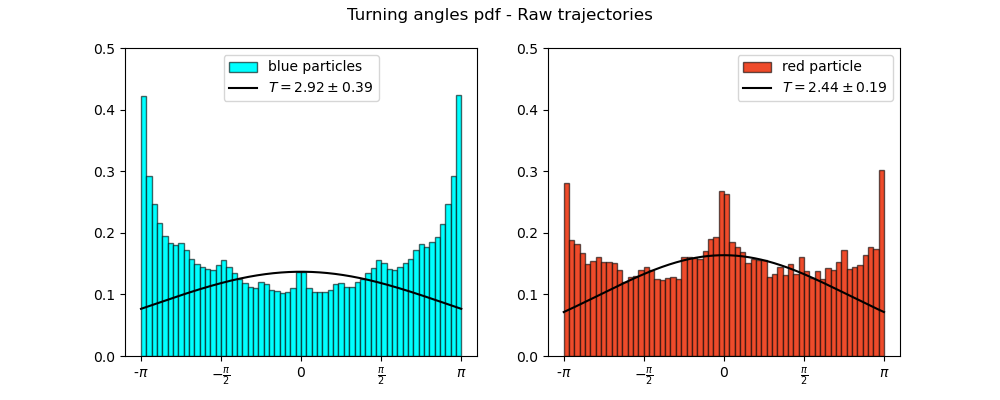

In [43]:
fig, (ax, ax1) = plt.subplots(1, 2, figsize=(10, 4))
ax.hist(theta_blue, bin_borders_turn, **default_kwargs_blue, label="blue particles")
ax.plot(x_interval_for_fit_turn, normal_distr(x_interval_for_fit_turn, *T_blue_rot), 'k-',
                label = f"$T = {T_blue_rot[0]:.2f} \pm {T_blue_rot_std[0]:.2f}$")
ax.set_xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],[r'-$\pi$', r'$-\frac{\pi}{2}$', '$0$', r'$\frac{\pi}{2}$', r'$\pi$'])
ax.legend()
ax.set_ylim(0,0.5)

ax1.hist(theta_red, bin_borders_turn, **default_kwargs_red, label="red particle")
ax1.plot(x_interval_for_fit_turn, normal_distr(x_interval_for_fit_turn, *T_red_rot), 'k-',
                label = f"$T = {T_red_rot[0]:.2f} \pm {T_red_rot_std[0]:.2f}$")
ax1.set_xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],[r'-$\pi$', r'$-\frac{\pi}{2}$', '$0$', r'$\frac{\pi}{2}$', r'$\pi$'])
ax1.legend()
ax1.set_ylim(0,0.5)
plt.suptitle("Turning angles pdf - Raw trajectories")
if save_verb: plt.savefig(f"../results/turning_angles/turn_ang_raw.png", dpi = 500, bbox_inches = 'tight')
if show_verb:
    plt.show()
else:
    plt.close()

In [45]:
theta_blue_smooth = ys.turning_angles_ensemble(blueTrajs_smooth, centered = True)
theta_red_smooth = ys.turning_angles_ensemble(redTraj_smooth, centered = True)

# normal distribution fit
bin_heights, _ = np.histogram(theta_blue_smooth, bins = bin_borders_turn, density = True)
T_blue_rot_smooth, pcov = curve_fit(normal_distr, bin_centers_turn, bin_heights, p0 = [1.])
T_blue_rot_smooth_std = np.sqrt(np.diag(pcov))
print(f"Blue fit: {T_blue_rot_smooth[0]}", f"{T_blue_rot_smooth_std[0]}")

bin_heights, _ = np.histogram(theta_red_smooth, bins = bin_borders_turn, density = True)
T_red_rot_smooth, pcov = curve_fit(normal_distr, bin_centers_turn, bin_heights, p0 = [1.])
T_red_rot_smooth_std = np.sqrt(np.diag(pcov))
print(f"Red fit: {T_red_rot_smooth[0]}", f"{T_red_rot_smooth_std[0]}")

Blue fit: 0.454524057619268 0.0156635674364005
Red fit: 0.19912360372536791 0.006229516007043429


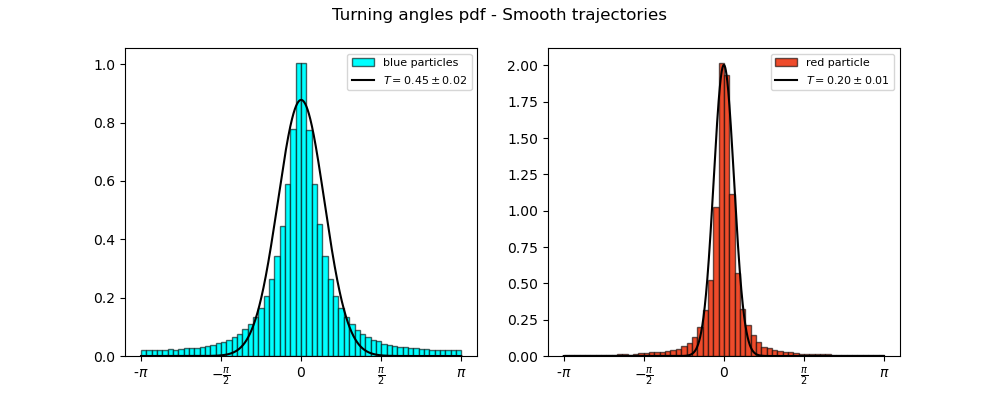

In [46]:
fig, (ax, ax1) = plt.subplots(1, 2, figsize=(10, 4))
ax.hist(theta_blue_smooth, bin_borders_turn, **default_kwargs_blue, label="blue particles")
ax.plot(x_interval_for_fit_turn, normal_distr(x_interval_for_fit_turn,* T_blue_rot_smooth), 'k-',
                label = f"$T = {T_blue_rot_smooth[0]:.2f} \pm {T_blue_rot_smooth_std[0]:.2f}$")
ax.set_xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],[r'-$\pi$', r'$-\frac{\pi}{2}$', '$0$', r'$\frac{\pi}{2}$', r'$\pi$'])
ax.legend(prop={'size': 8})

ax1.hist(theta_red_smooth, bin_borders_turn, **default_kwargs_red, label="red particle")
ax1.plot(x_interval_for_fit_turn, normal_distr(x_interval_for_fit_turn, *T_red_rot_smooth), 'k-',
                label = f"$T = {T_red_rot_smooth[0]:.2f} \pm {T_red_rot_smooth_std[0]:.2f}$")
ax1.set_xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],[r'-$\pi$', r'$-\frac{\pi}{2}$', '$0$', r'$\frac{\pi}{2}$', r'$\pi$'])
ax1.legend(prop={'size': 8})

plt.suptitle("Turning angles pdf - Smooth trajectories")
if save_verb: plt.savefig(f"../results/turning_angles/turn_ang_smooth.png", dpi = 500, bbox_inches = 'tight')
if show_verb:
    plt.show()
else:
    plt.close()

## Windowed Raw Trajectory

In [ ]:
theta_blue_windowed = []
theta_red_windowed = []
for k in tqdm(range(nSteps)):
    trajs = rawTrajs.loc[rawTrajs.frame.between(startFrames[k], endFrames[k])]
    blueTrajs = []
    redTraj = []

    for i in range(0, nDrops):
        if i == red_particle_idx:
            p = trajs.loc[trajs.particle==i, ["x","y"]]
            redTraj.append(Trajectory(p.x, p.y, dt = 1/10, traj_id=i))
        else:
            p = trajs.loc[trajs.particle==i, ["x","y"]]
            blueTrajs.append(Trajectory(p.x, p.y, dt = 1/10, traj_id=i))

    theta_blue_windowed.append(ys.turning_angles_ensemble(blueTrajs, centered= True))
    theta_red_windowed.append(ys.turning_angles_ensemble(redTraj, centered= True))

In [ ]:
blue_fit_windowed_turn = np.ones((nSteps, 2))
red_fit_windowed_turn = np.ones((nSteps, 2))

for k in range(nSteps):
    bin_heights, _ = np.histogram(theta_blue_windowed[k], bins = bin_borders_turn, density = True)
    blue_fit_windowed_turn[k, 0], pcov = curve_fit(normal_distr, bin_centers_turn, bin_heights, p0 = [1.])
    blue_fit_windowed_turn[k, 1] = np.sqrt(np.diag(pcov))

    bin_heights, _ = np.histogram(theta_blue_windowed[k], bins = bin_borders_turn, density = True)
    red_fit_windowed_turn[k, 0], pcov = curve_fit(normal_distr, bin_centers_turn, bin_heights, p0 = [1.])
    red_fit_windowed_turn[k, 1] = np.sqrt(np.diag(pcov))

In [ ]:
fig, (ax,ax1) = plt.subplots(2, 1, figsize=(8, 5))
anim_running = True

def onClick(event):
    global anim_running
    if anim_running:
        ani.event_source.stop()
        anim_running = False
    else:
        ani.event_source.start()
        anim_running = True


def prepare_animation(bar_container, bar_container2):
    def animate(frame):
        title.set_text(f"Turning angles pdf - Raw Trajectories - window {startFrames[frame]/10} - {endFrames[frame]/10} seconds")
        
        n, _ = np.histogram(theta_blue_windowed[frame], 100, density = True)
        for count, rect in zip(n, bar_container.patches):
            rect.set_height(count)
        line.set_ydata(normal_distr(x_interval_for_fit_turn, blue_fit_windowed_turn[frame, 0]))
            
        #title2.set_text(f"Red particle turning angles pdf {startFrames[frame]/10} - {endFrames[frame]/10} seconds")
        n2, _ = np.histogram(theta_red_windowed[frame], 100, density = True)
        for count2, rect2 in zip(n2, bar_container2.patches):
            rect2.set_height(count2)
        line1.set_ydata(normal_distr(x_interval_for_fit_turn, red_fit_windowed_turn[frame, 0]))
            
        return bar_container.patches, bar_container2.patches
    return animate

_, _, bar_container = ax.hist(theta_red_windowed[0], 100, **default_kwargs_blue, label="blue particles")
line, = ax.plot(x_interval_for_fit_turn, normal_distr(x_interval_for_fit_turn, blue_fit_windowed_turn[0, 0]), label='fit')
title = ax.set_title(f"Turning angles pdf - Raw Trajectories - window {startFrames[0]/10} - {endFrames[0]/10} seconds")
ax.set(ylabel = "pdf", ylim = (0, 1))
ax.set_xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi], [r'-$\pi$', r'$-\frac{\pi}{2}$', '$0$', r'$\frac{\pi}{2}$', r'$\pi$'])

_, _, bar_container2 = ax1.hist(theta_red_windowed[0], 100,  **default_kwargs_red, label="red particle")
line1, = ax1.plot(x_interval_for_fit_turn, normal_distr(x_interval_for_fit_turn, red_fit_windowed_turn[0, 0]), label='fit')
#title2 = ax1.set_title(f"Red particle turning angles pdf {startFrames[0]/10} - {endFrames[0]/10} seconds")
ax1.set(ylabel = "pdf", ylim = (0, 1))
ax1.set_xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi], [r'-$\pi$', r'$-\frac{\pi}{2}$', '$0$', r'$\frac{\pi}{2}$', r'$\pi$'])


plt.tight_layout()
fig.canvas.mpl_connect('button_press_event', onClick)
ani = matplotlib.animation.FuncAnimation(fig, prepare_animation(bar_container, bar_container2), nSteps, repeat=True, blit=False)
if save_verb: ani.save('../results/turning_angles/turn_ang_windowed_raw.mp4', fps=30, extra_args=['-vcodec', 'libx264'])

if anim_show_verb:
    plt.show()
else:
    plt.close()

In [ ]:
fig, (ax, ax1) = plt.subplots(2, 1, figsize=(8, 4), sharex=True)
ax.plot(startFrames/10, blue_fit_windowed_turn[:, 0], 'b', label="blue particles")
ax.fill_between(startFrames/10, blue_fit_windowed_turn[:, 0] - blue_fit_windowed_turn[:, 1],
                 blue_fit_windowed_turn[:, 0] + blue_fit_windowed_turn[:, 1], color='b', alpha=0.2)
ax.set(ylabel = "T [??]", ylim = (1, 5), title = "Effective Temperature - Raw Trajectories")
ax.legend()
ax.grid()

ax1.plot(startFrames/10, red_fit_windowed_turn[:, 0], 'r', label="red particles")
ax1.fill_between(startFrames/10, red_fit_windowed_turn[:, 0] - red_fit_windowed_turn[:, 1],
                    red_fit_windowed_turn[:, 0] + red_fit_windowed_turn[:, 1], color='r', alpha=0.2)
ax1.set(xlabel ="time [s]", ylabel = "T [??]")
ax1.legend()
ax1.grid()

plt.tight_layout()
if save_verb: plt.savefig('../results/turning_angles/effective_T_raw.png', dpi=500, bbox_inches='tight')
if show_verb:
    plt.show()
else:
    plt.close()

## Windowed Smooth Trajectory

In [7]:
theta_blue_windowed_smooth = []
theta_red_windowed_smooth = []
for k in tqdm(range(nSteps)):
    trajs = smoothTrajs.loc[rawTrajs.frame.between(startFrames[k], endFrames[k])]
    blueTrajs = []
    redTraj = []

    for i in range(0, nDrops):
        if i == red_particle_idx:
            p = trajs.loc[trajs.particle==i, ["x","y"]]
            redTraj.append(Trajectory(p.x, p.y, dt = 1/10, traj_id=i))
        else:
            p = trajs.loc[trajs.particle==i, ["x","y"]]
            blueTrajs.append(Trajectory(p.x, p.y, dt = 1/10, traj_id=i))
        

    theta_blue_windowed_smooth.append(ys.turning_angles_ensemble(blueTrajs, centered= True))
    theta_red_windowed_smooth.append(ys.turning_angles_ensemble(redTraj, centered= True))

100%|██████████| 288/288 [00:41<00:00,  7.02it/s]


In [8]:
blue_fit_windowed_turn_smooth = np.ones((nSteps, 2))
red_fit_windowed_turn_smooth = np.ones((nSteps, 2))

for k in range(nSteps):
    bin_heights, _ = np.histogram(theta_blue_windowed_smooth[k], bins = bin_borders_turn, density = True)
    blue_fit_windowed_turn_smooth[k, 0], pcov = curve_fit(normal_distr, bin_centers_turn, bin_heights, p0 = [1.])
    blue_fit_windowed_turn_smooth[k, 1] = np.sqrt(np.diag(pcov))

    bin_heights, _ = np.histogram(theta_blue_windowed_smooth[k], bins = bin_borders_turn, density = True)
    red_fit_windowed_turn_smooth[k, 0], pcov = curve_fit(normal_distr, bin_centers_turn, bin_heights, p0 = [1.])
    red_fit_windowed_turn_smooth[k, 1] = np.sqrt(np.diag(pcov))

In [9]:
fig, (ax, ax1) = plt.subplots(2, 1, figsize=(8, 5))
anim_running = True

def onClick(event):
    global anim_running
    if anim_running:
        ani.event_source.stop()
        anim_running = False
    else:
        ani.event_source.start()
        anim_running = True

def prepare_animation(bar_container, bar_container2):
    def animate(frame):
        title.set_text(f"Turning angles pdf - Smooth Trajectories - window {startFrames[frame]/10} - {endFrames[frame]/10} seconds")
        n, _ = np.histogram(theta_blue_windowed_smooth[frame], 100, density = True)
        for count, rect in zip(n, bar_container.patches):
            rect.set_height(count)
        line.set_ydata(normal_distr(x_interval_for_fit_turn, blue_fit_windowed_turn_smooth[frame, 0]))
            
        n2, _ = np.histogram(theta_red_windowed_smooth[frame], 100, density = True)
        for count2, rect2 in zip(n2, bar_container2.patches):
            rect2.set_height(count2)
        
        line1.set_ydata(normal_distr(x_interval_for_fit_turn, red_fit_windowed_turn_smooth[frame, 0]))
            
        return bar_container.patches, bar_container2.patches
    return animate

_, _, bar_container = ax.hist(theta_red_windowed_smooth[0], 100, **default_kwargs_blue, label="blue particles")
line, = ax.plot(x_interval_for_fit_turn, normal_distr(x_interval_for_fit_turn, blue_fit_windowed_turn_smooth[0, 0]), label='fit')
title = ax.set_title(f"Turning angles pdf - Smooth Trajectories - window {startFrames[0]/10} - {endFrames[0]/10} seconds")

ax.set(ylabel = "pdf", ylim = (0, 3))
ax.set_xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi], [r'-$\pi$', r'$-\frac{\pi}{2}$', '$0$', r'$\frac{\pi}{2}$', r'$\pi$'])

_, _, bar_container2 = ax1.hist(theta_red_windowed_smooth[0], 100,  **default_kwargs_red, label="red particle")
line1, = ax1.plot(x_interval_for_fit_turn, normal_distr(x_interval_for_fit_turn, red_fit_windowed_turn_smooth[0, 0]), label='fit')
ax1.set(ylabel = "pdf", ylim = (0, 3))
ax1.set_xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi], [r'-$\pi$', r'$-\frac{\pi}{2}$', '$0$', r'$\frac{\pi}{2}$', r'$\pi$'])

plt.tight_layout()
fig.canvas.mpl_connect('button_press_event', onClick)
ani = matplotlib.animation.FuncAnimation(fig, prepare_animation(bar_container, bar_container2), nSteps, repeat=True, blit=False)
ani.save('../results/turning_angles/turn_ang_windowed_smooth.mp4', fps=30, extra_args=['-vcodec', 'libx264'])
if anim_show_verb:
    plt.show()
else:
    plt.close()

11:47:07 [INFO] Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
11:47:07 [INFO] MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 800x500 -pix_fmt rgba -r 30 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -vcodec libx264 -y ../results/turning_angles/turn_ang_windowed_smooth.mp4


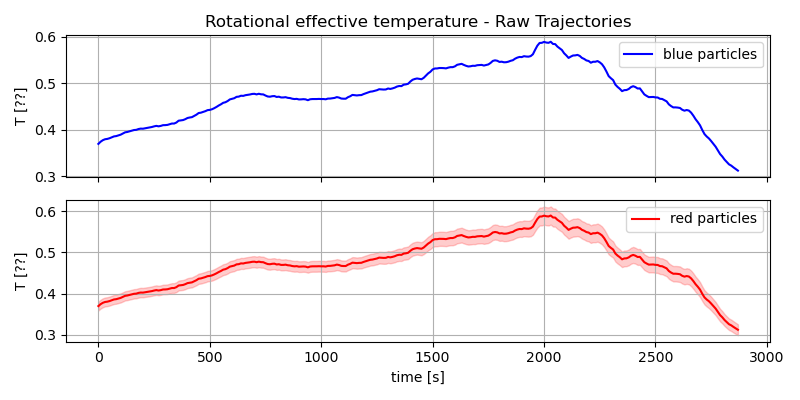

In [10]:
fig, (ax, ax1) = plt.subplots(2, 1, figsize=(8, 4), sharex=True)
ax.plot(startFrames/10, blue_fit_windowed_turn_smooth[:, 0], 'b', label="blue particles")

ax.set(ylabel = "T [??]", title = "Rotational effective temperature - Raw Trajectories")
ax.legend()
ax.grid()

ax1.plot(startFrames/10, red_fit_windowed_turn_smooth[:, 0], 'r', label="red particles")
ax1.fill_between(startFrames/10, red_fit_windowed_turn_smooth[:, 0] - red_fit_windowed_turn_smooth[:, 1],
                        red_fit_windowed_turn_smooth[:, 0] + red_fit_windowed_turn_smooth[:, 1], color='r', alpha=0.2)
ax1.set(xlabel = "time [s]", ylabel = "T [??]")
ax1.legend()
ax1.grid()

plt.tight_layout()
if save_verb: plt.savefig('../results/turning_angles/effective_T_smooth.png', dpi=500, bbox_inches='tight')
if show_verb:
    plt.show()
else:
    plt.close()

# Velocity autocorrelation
[ref](https://en.wikipedia.org/wiki/Autocovariance)

doubt: is this really a WSS process ? if not we shoud compute the autocovariance, not the pearson correlation diffusion

note: yupi vacf in time_avg mode performs autocovariance actually, not the autocorrelation

$$ K_{XX}(t_1, t_2) = cov \big[X_{t_1} , X_{t_2} \big] = E \big[ (X_{t_1} - \mu_{t_1}) (X_{t_2} - \mu_{t_2}) \big] = E \big[ X_{t_1}, X_{t_2} \big] - \mu_{t_1} \mu_{t_2} $$

then if the process is a weakly stationary (WSS) process, that is $\mu_{t_1} = \mu_{t_2} \; \forall \; t_1, t_2$ and $E\big[|X_t|^2\big] < \inf \; \forall \; t$ one has:


$$ K_{XX}(\tau) = E \big[ (X_t - \mu_t) (X_{t-\tau} - \mu_t) \big] $$

todo: modify code of yupy to get autocovariance at lag time 0 obtaining $\sigma^2$, which can be used to normalize the autocovariance

done: modified yupi source code at ../pyenv/lib/python3.10/site-packages/yupi/stats/_stats.py, 

original :

    for lag_ in range(1, lag + 1):
        # Multiply components given lag
        v1, v2 = v[:-lag_], v[lag_:]
        v1v2 = (v1 - v1.mean(axis=0)) * (v2 - v2.mean(axis=0))

        # Dot product for a given lag time
        v1_dot_v2 = np.sum(v1v2, axis=1)

        # Averaging over a single realization
        current_vacf[lag_ - 1] = np.mean(v1_dot_v2)


    vacf_mean = np.mean(_vacf, axis=1)  # Mean    
    vacf_std = np.std(_vacf, axis=1)  # Standard deviation

modified:

    for lag_ in range(lag):
        if lag_ == 0: v1, v2 = v[:], v[:]
        else: v1, v2 = v[:-lag_], v[lag_:]
        # Multiply components given lag
        v1v2 = (v1 - v1.mean(axis=0)) * (v2 - v2.mean(axis=0))

        # Dot product for a given lag time
        v1_dot_v2 = np.sum(v1v2, axis=1)

        # Averaging over a single realization
        current_vacf[lag_] = np.mean(v1_dot_v2)
                    

    vacf_mean = np.mean(_vacf/_vacf[0], axis=1)  # Mean
    vacf_std = np.std(_vacf/_vacf[0], axis=1)  # Standard deviation

## Global

In [ ]:
# raw trajectories
blueTrajs = []
redTraj = []
for i in range(0, nDrops):
    if i == red_particle_idx:
        p = rawTrajs.loc[rawTrajs.particle == i, ["x","y"]]
        redTraj.append(Trajectory(p.x, p.y, dt = 1/10, traj_id=i))
    else:
        p = rawTrajs.loc[rawTrajs.particle == i, ["x","y"]]
        blueTrajs.append(Trajectory(p.x, p.y, dt = 1/10, traj_id=i))
    

# smooth trajectories
blueTrajs_smooth = []
redTraj_smooth = []
for i in range(0, nDrops):
    if i == red_particle_idx:
        p = smoothTrajs.loc[smoothTrajs.particle == i, ["x","y"]]
        redTraj_smooth.append(Trajectory(p.x, p.y, dt = 1/10, traj_id=i))
    else:
        p = smoothTrajs.loc[smoothTrajs.particle == i, ["x","y"]]
        blueTrajs_smooth.append(Trajectory(p.x, p.y, dt = 1/10, traj_id=i))

In [ ]:
# check for WSS process applicability
diff = np.empty((len(blueTrajs), 1000))
for i, traj in enumerate(blueTrajs):
    v = traj.v
    for lag_ in range(1, 1000 + 1):
        # Multiply components given lag
        v1, v2 = v[:-lag_], v[lag_:]
        diff[i, lag_-1] = np.linalg.norm(v1.mean(axis=0)) - np.linalg.norm(v2.mean(axis=0))
print(np.mean(diff))

In [ ]:
maxLagtime = 1000
#x = np.arange(0.1, 100.1, 0.1) # without initial point
x = np.arange(0, 100, 0.1) # with initial point

vacf_mean_blue, vacf_std_blue = ys.vacf(blueTrajs, time_avg=True, lag=maxLagtime)
vacf_mean_red, vacf_std_red = ys.vacf(redTraj, time_avg=True, lag=maxLagtime)

fig, (ax, ax1) = plt.subplots(2, 1, figsize=(10, 5))
ax.errorbar(x, vacf_mean_blue, fmt='o', markersize=1, color = "blue", label = 'blue particles')
ax.fill_between(x, vacf_mean_blue + vacf_std_blue, vacf_mean_blue - vacf_std_blue,
                     alpha=1, edgecolor='#F0FFFF', facecolor='#00FFFF')
ax.grid()
ax.legend()
ax.set(xlim=(-1, 10), xlabel = 'Lag time [s]', ylabel = r'VACF [$(px/s)^2$]')
ax1.errorbar(x, vacf_mean_red, yerr=vacf_std_red, fmt='o',
                 markersize=1, color = "red", label = 'red particle')
ax1.set(xlim=(-1, 40), xlabel = 'Lag time [s]', ylabel = r'VACF [$(px/s)^2$]')
ax1.grid()
ax1.legend()
plt.suptitle("Velocity autocorrelation function, raw trajectories")
plt.tight_layout()
if save_verb: plt.savefig("../results/velocity_autocovariance/vacf_raw_with_initial_point.png", dpi = 500, bbox_inches='tight')
if show_verb: 
    plt.show()
else:
    plt.close()

In [ ]:
vacf_mean_blue_smooth, vacf_std_blue_smooth = ys.vacf(blueTrajs_smooth, time_avg=True, lag=maxLagtime)
vacf_mean_red_smooth, vacf_std_red_smooth = ys.vacf(redTraj_smooth, time_avg=True, lag=maxLagtime)

#x = np.arange(0.1, 100.1, 0.1) # without initial point
x = np.arange(0, 100, 0.1) # with initial point

fig, (ax, ax1) = plt.subplots(2, 1, figsize=(10, 5))
ax.errorbar(x, vacf_mean_blue_smooth, fmt='o', markersize=1, color = "blue", label = 'blue particles')
ax.fill_between(x, vacf_mean_blue_smooth + vacf_std_blue_smooth, vacf_mean_blue_smooth - vacf_std_blue_smooth,
                     alpha=1, edgecolor='#F0FFFF', facecolor='#00FFFF')
ax.set(xlim=(-1, 10), xlabel = 'Lag time [s]', ylabel = r'VACF [$(px/s)^2$]')
ax.grid()
ax.legend()
ax1.errorbar(x, vacf_mean_red_smooth, yerr=vacf_std_red_smooth, fmt='o',
                 markersize=1, color = "red", label = 'red particle')
ax1.set(xlim=(-1, 40), xlabel = 'Lag time [s]', ylabel = r'VACF [$(px/s)^2$]')
ax1.grid()  
ax1.legend()
plt.suptitle("Velocity autocorrelation function, smooth trajectories")
plt.tight_layout()
if save_verb: plt.savefig("../results/velocity_autocovariance/vacf_smooth_with_initial_point.png", dpi = 500, bbox_inches='tight')
plt.show()
if show_verb: 
    plt.show()
else:
    plt.close()

## Windowed Analysis - Raw Trajectory

In [ ]:
if 1: 
    vacf_blue_windowed = []
    vacf_red_windowed = []

    for k in tqdm(range(nSteps)):
        trajs = rawTrajs.loc[rawTrajs.frame.between(startFrames[k], endFrames[k])]
        blueTrajs = []
        redTraj = []

        for i in range(0, nDrops):
            if i == red_particle_idx:
                p = trajs.loc[trajs.particle==i, ["x","y"]]
                redTraj.append(Trajectory(p.x, p.y, dt = 1/10, traj_id=i))
            else:
                p = trajs.loc[trajs.particle==i, ["x","y"]]
                blueTrajs.append(Trajectory(p.x, p.y, dt = 1/10, traj_id=i))

        vacf_blue_windowed.append(ys.vacf(blueTrajs, time_avg=True, lag=maxLagtime)[0])
        vacf_red_windowed.append(ys.vacf(redTraj, time_avg=True, lag=maxLagtime)[0])
        
    vacf_blue_windowed = pd.DataFrame(vacf_blue_windowed)
    vacf_red_windowed = pd.DataFrame(vacf_red_windowed)
    vacf_blue_windowed.to_csv("../data/csv/vacf_blue_windowed_with_initial_point.csv")
    vacf_red_windowed.to_csv("../data/csv/vacf_red_windowed_with_initial_point.csv")
else:
    vacf_blue_windowed = pd.read_csv("../data/csv/vacf_blue_windowed_with_initial_point.csv", index_col=0)
    vacf_red_windowed = pd.read_csv("../data/csv/vacf_red_windowed_with_initial_point.csv", index_col=0)

In [ ]:
fig = plt.figure(figsize=(8, 5))
anim_running = True

def onClick(event):
    global anim_running
    if anim_running:
        ani.event_source.stop()
        anim_running = False
    else:
        ani.event_source.start()
        anim_running = True

def update_graph(step):
    line.set_ydata(vacf_blue_windowed.iloc[step])
    #ax.set_ylim(1.2*min(vacf_blue_windowed.iloc[step]), 1.2*max(vacf_blue_windowed.iloc[step]))
    title.set_text(f"Velocity autocorrelation - Raw Trajectories - window [{startFrames[step]/10} - {endFrames[step]/10}] s")
    #ax1.set_ylim(1.2*min(vacf_red_windowed.iloc[step])-10, 1.2*max(vacf_red_windowed.iloc[step]))
    line1.set_ydata(vacf_red_windowed.iloc[step])
    return line, line1,

ax = fig.add_subplot(211)
title = ax.set_title(f"Velocity autocorrelation - Raw Trajectories - window [{startFrames[0]/10} - {endFrames[0]/10}] s")
line, = ax.plot(np.arange(0.1, 100.1, 0.1), vacf_blue_windowed.iloc[0], 'b-', label = 'Blue particles')
ax.set(ylabel = r'vacf [$(px/s)^2$]', xlabel = 'lag time $t$ [s]', xlim = (-1, 20), ylim = (-0.5, 1.2))
ax.grid()
ax.legend()

ax1 = fig.add_subplot(212)

line1, = ax1.plot(np.arange(0.1, 100.1, 0.1), vacf_red_windowed.iloc[0], 'r-', label = 'Red particle')
ax1.set(ylabel = r'vacf [$(px/s)^2$]', xlabel = 'lag time $t$ [s]', xlim = (-1, 20), ylim = (-0.5, 1.2))
ax1.grid()
ax1.legend()

plt.tight_layout()
fig.canvas.mpl_connect('button_press_event', onClick)
ani = matplotlib.animation.FuncAnimation(fig, update_graph, nSteps, interval = 5, blit=False)
ani.save('../results/velocity_autocovariance/vacf_windowed_raw_with_initial_point.mp4', fps=30, extra_args=['-vcodec', 'libx264'])
plt.close()

## Windowed Analysis - Smooth Trajectory

In [ ]:
if 1:
    vacf_blue_windowed_smooth = []
    vacf_red_windowed_smooth = []

    for k in tqdm(range(nSteps)):
        trajs = smoothTrajs.loc[smoothTrajs.frame.between(startFrames[k], endFrames[k])]
        blueTrajs = []
        redTraj = []

        for i in range(0, nDrops):
            if i == red_particle_idx:
                p = trajs.loc[trajs.particle==i, ["x","y"]]
                redTraj.append(Trajectory(p.x, p.y, dt = 1/10, traj_id=i))
            else:
                p = trajs.loc[trajs.particle==i, ["x","y"]]
                blueTrajs.append(Trajectory(p.x, p.y, dt = 1/10, traj_id=i))
            

        vacf_blue_windowed_smooth.append(ys.vacf(blueTrajs, time_avg=True, lag=maxLagtime)[0])
        vacf_red_windowed_smooth.append(ys.vacf(redTraj, time_avg=True, lag=maxLagtime)[0])
    
    vacf_blue_windowed_smooth = pd.DataFrame(vacf_blue_windowed_smooth)
    vacf_red_windowed_smooth = pd.DataFrame(vacf_red_windowed_smooth)
    vacf_blue_windowed_smooth.to_csv("../data/csv/vacf_blue_windowed_smooth_with_initial_point.csv")
    vacf_red_windowed_smooth.to_csv("../data/csv/vacf_red_windowed_smooth_with_initial_point.csv")
else:
    vacf_blue_windowed_smooth = pd.read_csv("../data/csv/vacf_blue_windowed_smooth_with_initial_point.csv", index_col=0)
    vacf_red_windowed_smooth = pd.read_csv("../data/csv/vacf_red_windowed_smooth_with_initial_point.csv", index_col=0)

In [ ]:
fig = plt.figure(figsize=(8, 5))
anim_running = True

def onClick(event):
    global anim_running
    if anim_running:
        ani.event_source.stop()
        anim_running = False
    else:
        ani.event_source.start()
        anim_running = True

def update_graph(step):
    line.set_ydata(vacf_blue_windowed_smooth.iloc[step])
    ax.set_ylim(1.5*min(vacf_blue_windowed_smooth.iloc[step])-10, 1.5*max(vacf_blue_windowed_smooth.iloc[step])-10)
    title.set_text(f"Velocity autocorrelation - Smooth Trajectories - window [{startFrames[step]/10} - {endFrames[step]/10}] s")
    ax1.set_ylim(1.5*min(vacf_red_windowed_smooth.iloc[step])-10, 1.5*max(vacf_red_windowed_smooth.iloc[step])-10)
    line1.set_ydata(vacf_red_windowed_smooth.iloc[step])
    return line, line1,

ax = fig.add_subplot(211)
title = ax.set_title(f"Velocity autocorrelation - Smooth Trajectories - window [{startFrames[0]/10} - {endFrames[0]/10}] s")
line, = ax.plot(np.arange(0.1, 100.1, 0.1), vacf_blue_windowed_smooth.iloc[0], 'b-', label = 'Blue particles')
ax.set(ylabel = r'vacf [$(px/s)^2$]', xlabel = 'lag time $t$ [s]', xlim = (-1, 20))
ax.grid()
ax.legend()

ax1 = fig.add_subplot(212)
line1, = ax1.plot(np.arange(0.1, 100.1, 0.1), vacf_red_windowed_smooth.iloc[0], 'r-', label = 'Red particle')
ax1.set(ylabel = r'vacf [$(px/s)^2$]', xlabel = 'lag time $t$ [s]', xlim = (-1, 20))
ax1.grid()
ax1.legend()

plt.tight_layout()
fig.canvas.mpl_connect('button_press_event', onClick)
ani = matplotlib.animation.FuncAnimation(fig, update_graph, nSteps, interval = 5, blit=False)
ani.save('../results/velocity_autocovariance/vacf_windowed_smooth_with_initial_point.mp4', fps=30, extra_args=['-vcodec', 'libx264'])
plt.show()

# Other Metrics

In [ ]:
kurt_ref_blue = ys.kurtosis_reference(blueTrajs)
kurt_mean_blue, _ = ys.kurtosis(blueTrajs, time_avg=True, lag=maxLagtime)

kurt_ref_red = ys.kurtosis_reference(redTraj)
kurt_mean_red, _ = ys.kurtosis(redTraj, time_avg=True, lag=maxLagtime)

In [ ]:
fig, ax = plt.subplots()
plt.subplot(121)
yg.plot_kurtosis(kurt_mean_blue, kurtosis_ref=kurt_ref_blue, dt=1/10, show=False)
plt.subplot(122)
yg.plot_kurtosis(kurt_mean_red, kurtosis_ref=kurt_ref_red, dt=1/10, show=False)
plt.show()

In [ ]:
psd_mean_blue, psd_std_blue, frec_blue = ys.psd(blueTrajs, lag=maxLagtime)
psd_mean_red, psd_std_red, frec_red = ys.psd(redTraj, lag=maxLagtime)
fig = plt.figure()
plt.subplot(121)
yg.plot_psd(psd_mean_blue, frec_blue, psd_std_blue, show=False)
plt.subplot(122)
yg.plot_psd(psd_mean_red, frec_red, psd_std_red, show=False)
plt.show()

# Radial Distribution Function


The radial distribution function in 2D is:
$$ g_2(r) = \frac{n(r)}{\pi [(r+\delta r)^2 - r^2 ] \rho} $$

where the density is $\rho = N/V $ and the number density $n(r)$ is computed (using a KDTree data structure) by taking the number of elements closer than $r + \delta r$ minus the number of elements closer than $r$

In 3D (i think):
$$ S_r = 4 \pi r^2 g_2(r) $$

in 2D ???

## regular

In [ ]:
@joblib.delayed
def computeRadialDistributionFunction(frame, COORDS, rList, dr, rho):
    coords = COORDS[frame*nDrops:(frame+1)*nDrops,:]
    kd = KDTree(coords)

    avg_n = np.zeros(len(rList))
    for i, r in enumerate(rList):
        a = kd.query_ball_point(coords, r + 20)
        b = kd.query_ball_point(coords, r)
        
        n1 = 0
        for j in a:
            n1 += len(j) - 1

        n2 = 0
        for j in b:
            n2 += len(j) - 1
        
        avg_n[i] = n1/len(a) - n2/len(b)

    g2 = avg_n/(np.pi*(dr**2 + 2*rList*dr)*rho)
    return g2

In [ ]:
dr = 5
rDisk = 822/2
rList = np.arange(0, 2*rDisk, 1)
rho = nDrops/(np.pi*rDisk**2) # nDrops -1 !

COORDS = np.array(rawTrajs.loc[:,["x","y"]])

In [ ]:
parallel = joblib.Parallel(n_jobs = -2)
frames = 200
trial = parallel(
    computeRadialDistributionFunction(frame, COORDS, rList, dr, rho)
    for frame in tqdm( range(frames) )
)
trial = np.array(trial)

In [ ]:
fig, ax = plt.subplots()
anim_running = True

def onClick(event):
    global anim_running
    if anim_running:
        ani.event_source.stop()
        anim_running = False
    else:
        ani.event_source.start()
        anim_running = True

line, = ax.plot(rList, trial[0])
title = ax.set_title('Test, time=0')

def animate(frame):
    line.set_ydata(trial[frame])  # update the data.
    title.set_text('Test, time={}'.format(frame))
    ax.set_ylim(-1, max(trial[frame]) + 4)
    return line, 

fig.canvas.mpl_connect('button_press_event', onClick)
ani = matplotlib.animation.FuncAnimation(fig, animate, range(0, frames), interval=20, blit=False)
plt.show()

### RDF analysis with full dataset already computed

In [ ]:
g2 = np.array(pd.read_csv("/Users/matteoscandola/thesis/data/g2.csv"))

In [ ]:
g2.shape

In [ ]:
g_plot = g2[::30, :].T

timearr = np.linspace(0, 30000, 10)/10
timearr = timearr.astype(int)


fig, ax = plt.subplots(1, 1, figsize=(8,6))
img = ax.imshow(np.log(1 + g_plot))
ax.set_xticks(np.linspace(0, g_plot.shape[1], 10))
ax.set_yticks(np.linspace(0, g_plot.shape[0], 10))
ax.set_xticklabels(timearr)
ax.set_yticklabels(np.linspace(0, 2*rDisk, 10).astype(int))
fig.colorbar(img)
plt.xlabel("Time [s]")
plt.ylabel("r [px]")
plt.title("$Log(1 + g_2)$ heatmap ")
plt.show()

In [ ]:
fig, ax = plt.subplots()
ax.errorbar(rList, np.mean(g2, axis = 0), yerr = np.std(g2, axis = 0), marker = ".")
#ax.plot(rList, g2[0])
ax.set_ylabel("$g \; (r)$")
ax.set_xlabel("r")
#ax.set_xlim(-5, 600)
plt.show()

#### Moving averages

In [ ]:
# axis = 0 --> Time moving average
# axis = 1 --> Radius moving average
def running_mean_uniform_filter1d(x, N, AX):
    return uniform_filter1d(x, N, mode='constant', axis = AX, origin=-(N//2))#[:-(N-1)]

##### r-averaged

In [ ]:
g2_r_avg = running_mean_uniform_filter1d(g2, 5, 1)

In [ ]:
fig, ax = plt.subplots()
#ax.plot(rList, g2_r_avg[0])
ax.plot(rList, g2[0])
ax.set_ylabel("$g \; (r)$")
ax.set_xlabel("r")
#ax.set_xlim(-5, 600)
plt.show()

In [ ]:
fig, ax = plt.subplots()
anim_running = True

def onClick(event):
    global anim_running
    if anim_running:
        ani.event_source.stop()
        anim_running = False
    else:
        ani.event_source.start()
        anim_running = True

line, = ax.plot(rList, g2_r_avg[0])
title = ax.set_title('Test, time=0')

def animate(frame):
    line.set_ydata(g2_r_avg[frame])  # update the data.
    title.set_text('Test, time={}'.format(frame))
    ax.set_ylim(-1, max(g2_r_avg[frame]) + 4)
    return line, 

fig.canvas.mpl_connect('button_press_event', onClick)
ani = matplotlib.animation.FuncAnimation(fig, animate, range(0, 30000, 5), interval=2, blit=False)
plt.show()

In [ ]:
g2_r_avg.shape
g2.shape

In [ ]:
nFrames = 30000
rmax = np.zeros(nFrames)
rmax_r_avg = np.zeros(nFrames)

rMin = 200

for i in range(nFrames):
    rmax[i] = rList[np.where(g2[i]==0)[0][np.where(g2[i]==0)[0]>rMin][0]]
    rmax_r_avg[i] = rList[np.where(g2_r_avg[i]==0)[0][np.where(g2_r_avg[i]==0)[0]>rMin][0]]
    
framesList = np.arange(0, nFrames, 1)

fig, (ax, ax1) = plt.subplots(1, 2)

ax.plot(framesList, rmax)
ax1.plot(framesList, rmax_r_avg)

ax.set_title("$R_{max}$")
ax1.set_title("Moving average $R_{max}$")
plt.show()

##### time averaged 

In [ ]:
g2_time_avg = running_mean_uniform_filter1d(g2, 50, 0)

In [ ]:
fig, ax = plt.subplots()
ax.plot(rList, g2_time_avg[0])
ax.plot(rList, g2[0])
ax.set_ylabel("$g \; (r)$")
ax.set_xlabel("r")
#ax.set_xlim(-5, 600)
plt.show()

In [ ]:
fig, ax = plt.subplots()
anim_running = True

def onClick(event):
    global anim_running
    if anim_running:
        ani.event_source.stop()
        anim_running = False
    else:
        ani.event_source.start()
        anim_running = True

line, = ax.plot(rList, g2_time_avg[0])
title = ax.set_title('Test, time=0')

def animate(frame):
    line.set_ydata(g2_time_avg[frame])  # update the data.
    title.set_text('Test, time={}'.format(frame))
    ax.set_ylim(-1, max(g2_r_avg[frame]) + 4)
    return line, 

fig.canvas.mpl_connect('button_press_event', onClick)
ani = matplotlib.animation.FuncAnimation(fig, animate, range(25000, nFrames), interval=2, blit=False)
#ani.save(f'/Users/matteoscandola/thesisData/rolled2.mp4', writer=writervideo)
#plt.show()

In [ ]:
rmax = np.zeros(nFrames)
rmax_roll = np.zeros(nFrames)

rMin = 450

for i in range(nFrames):
    rmax[i] = rList[np.where(g_2[i]==0)[0][np.where(g_2[i]==0)[0]>rMin][0]]
    rmax_roll[i] = rList[np.where(g_2_roll[i]==0)[0][np.where(g_2_roll[i]==0)[0]>rMin][0]]
    
framesList = np.arange(0, nFrames, 1)

fig, (ax, ax1) = plt.subplots(1, 2)

ax.plot(framesList, rmax)
ax1.plot(framesList, rmax_roll)

ax.set_title("$R_{max}$")
ax1.set_title("Moving average $R_{max}$")
plt.show()

## from centre

In [ ]:
@joblib.delayed
def computeRadialDistributionFunction(frame, COORDS, rList, dr, rho):
    coords = COORDS[frame*nDrops:(frame+1)*nDrops,:]
    kd = KDTree(coords)

    avg_n = np.zeros(len(rList))
    for i, r in enumerate(rList):
        a = kd.query_ball_point(coords, r + 20)
        b = kd.query_ball_point(coords, r)
        
        n1 = 0
        for j in a:
            n1 += len(j) - 1

        n2 = 0
        for j in b:
            n2 += len(j) - 1
        
        avg_n[i] = n1/len(a) - n2/len(b)

    g2 = avg_n/(np.pi*(dr**2 + 2*rList*dr)*rho)
    return g2

## Distance from centre of mass distribution with pca ??

In [ ]:
frame = 0
covMatrix = np.cov(COORDS[frame*nDrops:(frame+1)*nDrops,:])
trace_of_covMatrix = np.trace(covMatrix)
eigenvalues, _ = np.linalg.eigh(covMatrix)
#eigenvalues = np.sort(eigenvalues)[::-1]
#diagCovMatrix = np.diag(eigenvalues)
info = np.zeros(len(eigenvalues))
for i in range(len(eigenvalues)):
    info[i] = np.sum(np.sum(eigenvalues[:i]))
info /= trace_of_covMatrix